In [160]:
# -*- coding: utf-8 -*-
import warnings
import os.path
import sys
import pickle
import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import ow_f01, cxmn_train, cxmn_predict, predict_mean
from code.refactor.common import loadSettingsFromYamlFile, save_object, object2Float, get_column_by_type

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [161]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [162]:
p1_used_header = ['productkey', 'promotionkey', 'startdatetime', 'enddatetime', 'jdprice', 'syntheticgrossprice', 'promotiondesc', 'promotiondesc_flag', 'promotiontype', 'promotionsubtype',
                'areatypearray', 'tokenflag', 'directdiscount_discount', 'directdiscount_availabilitynumber', 'bundle_subtype1_threshold', 'bundle_subtype1_giveaway',
                'bundle_subtype4_threshold1', 'bundle_subtype4_giveaway1', 'bundle_subtype4_threshold2', 'bundle_subtype4_giveaway2', 'bundle_subtype4_threshold3',
                'bundle_subtype4_giveaway3', 'bundle_subtype2_threshold', 'bundle_subtype2_giveaway', 'bundle_subtype2_maximumgiveaway', 'bundle_subtype15_thresholdnumber1',
                'bundle_subtype15_giveawayrate1', 'bundle_subtype15_thresholdnumber2', 'bundle_subtype15_giveawayrate2', 'bundle_subtype15_thresholdnumber3',
                'bundle_subtype15_giveawayrate3', 'bundle_subtype6_thresholdnumber', 'bundle_subtype6_freenumber', 'suit_maxvaluepool', 'suit_minvaluepool', 'suit_avgvaluepool',
                'suit_discount', 'directdiscount_saleprice', 'bundle_subtype1_percent', 'bundle_subtype4_percent', 'bundle_subtype2_percent', 'bundle_subtype15_percent',
                'bundle_subtype6_percent', 'suit_percent', 'allpercentdiscount', 'mainproductkey', 'hierarchylevel3key', 'createdate', 'statuscode', 'dt']
p2_used_header = ['ProductKey', 'Date', 'HierarchyLevel3Key', 'PromotionCount', 'bundlecount', 'MaxDiscount', 'MinDiscount', 'AvgDiscount', 'MaxSyntheticDiscountA',
				         'MinSyntheticDiscountA', 'AvgSyntheticDiscountA', 'MaxBundleDiscount', 'MinBundleDiscount', 'AvgBundleDiscount', 'MaxDirectDiscount', 'MinDirectDiscount',
				         'AvgDirectDiscount', 'MaxFreegiftDiscount', 'MinFreegiftDiscount', 'AvgFreegiftDiscount', 'SyntheticGrossPrice', 'promotionkey', 'promotiontype',
				         'promotionsubtype', 'syntheticgrossprice_vb', 'jdprice', 'syntheticdiscounta_vb', 'durationinhours', 'daynumberinpromotion', 'bundleflag', 'directdiscountflag',
				         'freegiftflag', 'suitflag', 'numberproducts', 'numberhierarchylevel1', 'numberhierarchylevel2', 'numberhierarchylevel3', 'strongmark', 'stockprice', 'dt']
suffix = '.da'
item = 'p1'
for_what = ['train', 'predict']

In [279]:
def sarima_model(df_all_new,namecol, pre_start_date, pre_len=100,
                    types='day', zaixian=False):
    times = 0
    df_all_new = df_all_new.sort_values(namecol+['ds'])
    df_train_all = df_all_new[df_all_new.ds < pre_start_date]
    df_tmp_all = []
    numbers = 0
    pdq = {}
    PDQ = {}
    for key, group in df_train_all.groupby(namecol):

        print("######################")
        print(key)
        print("**********************")
        print(group.shape)
        if group['ds'].count() <= 2:
            continue
        print("-------------aaa-----------------------")
        df_group = group[['ds', 'y']].reset_index(drop=True)
        # df_group = df_group
        print(df_group.head())
        D_f = nsdiffs(df_group['y'], m=3, max_D=5, test='ch')
        d_f = ndiffs(df_group['y'], alpha=0.05, test='kpss', max_d=5)
        print('senson',D_f)
        print('diff',d_f)
        if len(df_group) <= 30:
            seasonal = False
        else:
            seasonal = True
        try:
            stepwise_fit = auto_arima(df_group['y'], start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                                      start_P=0, seasonal=seasonal, d=d_f, D=D_f, trace=True,
                                      error_action='ignore',  # don't want to know if an order does not work
                                      suppress_warnings=True,  # don't want convergence warnings
                                      stepwise=True)  # set to stepwise
        except:
            stepwise_fit = auto_arima(df_group['y'], start_p=0, start_q=0, max_p=3, max_q=0, m=12,
                                      start_P=0, seasonal=False, d=0, D=0, trace=True,
                                      error_action='ignore',  # don't want to know if an order does not work
                                      suppress_warnings=True,  # don't want convergence warnings
                                      stepwise=True)  # set to stepwise
        print(stepwise_fit.order)
        #key = str(key[0])+'#' + str(key[1])
        pdq[key] = stepwise_fit.order
        PDQ[key] = stepwise_fit.seasonal_order

        print(stepwise_fit.seasonal_order)
        print(stepwise_fit.aic())
        # break
        # historys = [float(i) for i in df_all_new['y'].values]
        # print(historys)
        # stepwise_fit = ARIMA(historys, order=(2 ,2 ,1))
        # stepwise_fit = stepwise_fit.fit(disp=0)
        output = stepwise_fit.predict(n_periods=pre_len)
        del stepwise_fit
        # if 'day' in types:
        #     future = prophet.make_future_dataframe(freq='D', periods=pre_len)
        # else:
        #     #######修改了freq（test）
        #     future = prophet.make_future_dataframe(freq='H', periods=pre_len)
        # print("-------------eee-----------------------")
        # forecast = prophet.predict(future)
        print("-------------fff-----------------------")
        forecast = pd.DataFrame(pd.date_range(pre_start_date, pre_start_date+pd.DateOffset(days=pre_len-1)))
        forecast.rename(columns={forecast.columns[0]: 'date'}, inplace=True)
        forecast['key_valid'] = key
        forecast['yhat'] = output
        df_tmp_all.append(forecast)
        # break
        numbers = numbers + 1
        print('#############################numbers##########', numbers)
        times += 1
        # if times == 4:
        #     break
        # break
        # print(df_tmp_all)
    df_forecast = pd.concat(df_tmp_all)
    #yaml_arima_parameter('./pdq.yaml',pdq)
    #yaml_arima_parameter('./PDQ_senson.yaml', PDQ)
    # df_result = df_forecast[df_forecast.ds >= pre_start_date][['key_valid', 'ds', 'yhat_lower', 'yhat_upper', 'yhat']]
    print('****************')
    # print(df_forecast[df_forecast.ds >= pre_start_date])
    print(df_forecast)
    print('***************')
    return df_forecast

In [163]:
def statitics_mape(new_df_final):
		new_df_sku = new_df_final.groupby('ProductKey').sum().reset_index()
		print "ensemble pred sum : %f"%(new_df_sku.ypred_mean_promo_new.sum())
		print "raw pred sum :      %f"%(new_df_sku.ypred_raw.sum())
		print "actual sum:         %f"%(new_df_sku.salesForecast.sum())

		print "raw pred residual:      %f"%(np.sum(np.abs(new_df_sku.ypred_raw - new_df_sku.salesForecast)))
		print "ensemble pred residual: %f"%(np.sum(np.abs(new_df_sku.ypred_mean_promo_new - new_df_sku.salesForecast)))

		print "raw pred mape: %f"%(np.sum(np.abs(new_df_sku.ypred_raw - new_df_sku.salesForecast)) / new_df_sku.salesForecast.sum())
		print "ensemble mape: %f"%(np.sum(np.abs(new_df_sku.ypred_mean_promo_new - new_df_sku.salesForecast)) / new_df_sku.salesForecast.sum())

In [164]:
def get_online_history_data():
    # p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_p1.da',sep='\t',header=None)
    # p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_p2.da',sep='\t',header=None)
    # ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_ts.da',sep='\t',header=None)
    # p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_p1.da', sep='\t', header=None)
    # p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_p2.da', sep='\t', header=None)
    # ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_ts.da', sep='\t', header=None)
    p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_p1.da', sep='\t', header=None)
    p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_p2.da', sep='\t', header=None)
    ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_ts.da', sep='\t', header=None)
    return p1,p2,ts


In [165]:
scenarioSettingsPath = 'code/refactor/ow_scenario.yaml'
scenario = loadSettingsFromYamlFile(scenarioSettingsPath)
area_rdc_map = pd.read_csv('/home/ubuntu/yulong/promotion_offline/tmp/ow_deploy_single/area_rdc_mapping.csv')
holidays_df=pd.read_csv('/home/ubuntu/yulong/promotion_offline/tmp/ow_deploy_single/holidays.csv')
seasonality_df = pd.read_csv('tmp/data/870_season.csv', parse_dates=['Date'])

In [166]:
cate = 736
pred_date = pd.to_datetime('2018-05-08')
scenario['lookforwardPeriodDays'] = 7

# cate = 7054
# pred_date = pd.to_datetime('2018-02-01')
# scenario['lookforwardPeriodDays'] = 10

# cate = 12029
# pred_date = pd.to_datetime('2018-05-07')
# scenario['lookforwardPeriodDays'] = 7


In [167]:
p1_df,p2_df,ts_df = get_online_history_data()

In [168]:
p1_df.columns = p1_used_header
p2_df.columns = p2_used_header


In [169]:
p2_df.head()

,ProductKey,Date,HierarchyLevel3Key,PromotionCount,bundlecount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,SyntheticGrossPrice,promotionkey,promotiontype,promotionsubtype,syntheticgrossprice_vb,jdprice,syntheticdiscounta_vb,durationinhours,daynumberinpromotion,bundleflag,directdiscountflag,freegiftflag,suitflag,numberproducts,numberhierarchylevel1,numberhierarchylevel2,numberhierarchylevel3,strongmark,stockprice,dt
0,2357674,2016-08-08,736,3,0,0.250000,0.211538,0.237179,0.0488,0.0000,0.03253333,0.0,0.0,0.0,0.250000,0.211538,0.237179,0.0,0.0,0.0,41.0,None,None,None,None,None,None,None,None,None,None,None,None,1,1,1,1,0,39.0,2016-08-08
1,393162,2016-08-08,736,2,0,0.123810,0.047619,0.085714,0.0800,0.0000,0.04000000,0.0,0.0,0.0,0.123810,0.047619,0.085714,0.0,0.0,0.0,100.0,None,None,None,None,None,None,None,None,None,None,None,None,1,1,1,1,0,85.0,2016-08-08
2,1171298,2016-08-08,736,4,0,0.176000,0.112000,0.142000,0.0550,-0.0183,0.01605000,0.0,0.0,0.0,0.176000,0.112000,0.142000,0.0,0.0,0.0,109.0,None,None,None,None,None,None,None,None,None,None,None,None,1,1,1,1,0,91.0,2016-08-08
3,559678,2016-08-08,736,3,0,0.069767,0.007752,0.041344,None,None,None,0.0,0.0,0.0,0.069767,0.007752,0.041344,0.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,1,1,1,1,0,107.5,2016-08-08
4,1504210,2016-08-08,736,3,0,0.181818,0.181818,0.181818,0.1818,0.1818,0.18180000,0.0,0.0,0.0,0.181818,0.181818,0.181818,0.0,0.0,0.0,22.0,None,None,None,None,None,None,None,None,None,None,None,None,1,1,1,1,0,15.4,2016-08-08


In [170]:
print p2_df.Date.min()
print p2_df.Date.max()

2015-01-01
2018-07-27


In [171]:
###handle p2
p2_df['Date'] = pd.to_datetime(p2_df['Date'])
p2_df['dt'] = pd.to_datetime(p2_df['dt'])
p2_df.replace('null', np.nan, inplace=True)
p2_df.replace('None', np.nan, inplace=True)
p2_df.replace(-999, np.nan, inplace=True)
p2_df.drop_duplicates(inplace=True)

# Convert Object -> float
if 'object' in p2_df.dtypes.values:
    obj_cols = get_column_by_type(p2_df,'object')
    object2Float(p2_df,obj_cols)


convert to Float columns:
MaxSyntheticDiscountA
convert to Float columns:
MinSyntheticDiscountA
convert to Float columns:
AvgSyntheticDiscountA
convert to Float columns:
SyntheticGrossPrice
convert to Float columns:
promotionkey
convert to Float columns:
promotiontype
convert to Float columns:
promotionsubtype
convert to Float columns:
syntheticgrossprice_vb
convert to Float columns:
jdprice
convert to Float columns:
syntheticdiscounta_vb
convert to Float columns:
durationinhours
convert to Float columns:
daynumberinpromotion
convert to Float columns:
bundleflag
convert to Float columns:
directdiscountflag
convert to Float columns:
freegiftflag
convert to Float columns:
suitflag
convert to Float columns:
stockprice


In [172]:
def handle_f01(p1_df, for_what, area_rdc_map, pred_date, scenario):
    for fw in for_what:
    	print "output and save: %s_p1_%s"%(str(cate),fw)
    	train_pred_gate = fw   # 'train'
    	f01_output = ow_f01.generate_f01_promo(area_rdc_map, p1_df, scenario, train_pred_gate, ForecastStartDate=pred_date)
    	if train_pred_gate == 'train':
    		train_p1_df = f01_output
    	else:
    		predict_p1_df = f01_output
    return train_p1_df, predict_p1_df
train_p1_df,predict_p1_df = handle_f01(p1_df, for_what, area_rdc_map, pred_date, scenario)


output and save: 736_p1_train
convert to Float columns:
allpercentdiscount
convert to Float columns:
bundle_subtype15_giveawayrate1
convert to Float columns:
bundle_subtype15_giveawayrate2
convert to Float columns:
bundle_subtype15_giveawayrate3
convert to Float columns:
bundle_subtype15_percent
convert to Float columns:
bundle_subtype15_thresholdnumber1
convert to Float columns:
bundle_subtype15_thresholdnumber2
convert to Float columns:
bundle_subtype15_thresholdnumber3
convert to Float columns:
bundle_subtype1_giveaway
convert to Float columns:
bundle_subtype1_percent
convert to Float columns:
bundle_subtype1_threshold
convert to Float columns:
bundle_subtype2_giveaway
convert to Float columns:
bundle_subtype2_maximumgiveaway
convert to Float columns:
bundle_subtype2_percent
convert to Float columns:
bundle_subtype2_threshold
convert to Float columns:
bundle_subtype4_giveaway1
convert to Float columns:
bundle_subtype4_giveaway2
convert to Float columns:
bundle_subtype4_giveaway3
con

In [173]:
print train_p1_df.shape
print predict_p1_df.shape

(819698, 23)
(245576, 23)


In [174]:
ts_df.columns = ['Date', 'ind', 'RDCKey', 'ProductKey', 'HierarchyLevel1Key', 'HierarchyLevel2Key', 'HierarchyLevel3Key', 'brand_code', 'sales', 'priceAfterDiscount', 'jd_prc', 'vendibility', 'counterState', 'salesForecast', 'reserveState', 'stockQuantity', 'utc_flag']
ts_df['Date'] = pd.to_datetime(ts_df['Date'])

ts_df.replace('null', np.nan, inplace=True)
ts_df.replace(-999, np.nan, inplace=True)
ts_df.replace('None', np.nan, inplace=True)
ts_to_float_col = ['RDCKey', 'ProductKey', 'HierarchyLevel1Key', 'HierarchyLevel2Key', 'HierarchyLevel3Key', 'brand_code', 'sales', 'priceAfterDiscount', 'jd_prc', 'vendibility', 'counterState', 'salesForecast', 'reserveState', 'stockQuantity', 'utc_flag']
if 'object' in ts_df[ts_to_float_col].dtypes.values:
    object2Float(ts_df,ts_to_float_col)


In [175]:
levels = ['HierarchyLevel3Key','ProductKey','RDCKey','Date']
ts_df.sort_values(levels, ascending=[True]*len(levels), inplace=True)
ts_df= ts_df.reset_index(drop=True)

In [176]:
ts_df.head()

,Date,ind,RDCKey,ProductKey,HierarchyLevel1Key,HierarchyLevel2Key,HierarchyLevel3Key,brand_code,sales,priceAfterDiscount,jd_prc,vendibility,counterState,salesForecast,reserveState,stockQuantity,utc_flag
0,2015-04-18,1197,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2015-04-19,1196,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2015-04-20,1195,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2015-04-21,1194,3,117064,670,729,736,8740,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,2015-04-22,1193,3,117064,670,729,736,8740,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [177]:
print ts_df.Date.min()
print ts_df.Date.max()

2015-04-18 00:00:00
2018-07-28 00:00:00


In [178]:
def train_model(area_rdc_map, train_p1_df, p2_df, ts_df, scenario, holidays_df, seasonality_df, pred_date):
	seasonality_df_train = seasonality_df.copy()
	model,feature=cxmn_train.train(area_rdc_map,train_p1_df,p2_df,ts_df,scenario,holidays_df,seasonality_df_train,process_f01_flag=False,mode='dev',ForecastStartDate=pred_date)
	#feature.to_csv(os.path.join(result_path, str(cate)+'/'+str(cate)+'_train_feature.csv'),index=False)
	#save_object(model, os.path.join(result_path, str(cate)+'/'+str(cate)+'_train_model.pkl'))
	return model, feature
model, feature = train_model(area_rdc_map, train_p1_df, p2_df, ts_df, scenario, holidays_df, seasonality_df, pred_date)


convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212
use cart feature?
False
| Add date features...
| - Add month of the year...
| - Add day of the week...
| Calculating national rolling features...
('| - Rolling value:', 'xxxHashColumn')
| - Rolling 14 mean...
| - Rolling 7 mean...
| - Rolling 5 mean...
| - Rolling 3 mean...
| - Rolling 2 mean...
| - Rolling 1 mean...
| - Rolling 14 median...
| - Rolling 7 median...
| - Rolling decay 28 mean...
| - Rolling decay 14 mean...
| - Rolling decay 7 mean...
| - Rolling decay 3 mean...
| - Added rolling features in 107.430709 seconds 

| Calculating  rolling features...
('| - Rolling value:', 'OrderNonOutlierVolume')
| - Rolling 360 mean...
| - Rolling 180 mean...
| - Rolling 90 mean...
| - Rolling 28 mean...
| - Rolling 

In [179]:
def predict_q_pred(area_rdc_map, predict_p1_df, p2_df, ts_df, scenario, holidays_df, seasonality_df, pred_date, model):
	seasonality_df_test = seasonality_df.copy()
	q_pred_result,df_fut=cxmn_predict.predict(area_rdc_map,predict_p1_df,p2_df,ts_df,scenario,holidays_df,model,seasonality_df_test,process_f01_flag=False,mode='dev',ForecastStartDate=pred_date)
	#q_pred_result.to_csv('tmp/data/test_0705/'+'result_'+str(cate)+'.csv',index=False)
	return q_pred_result, df_fut
q_pred_result, df_fut = predict_q_pred(area_rdc_map, predict_p1_df, p2_df, ts_df, scenario, holidays_df, seasonality_df, pred_date, model)


convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212
| Add date features...
| - Add month of the year...
| - Add day of the week...
| - group by SyntheticPromotionSubType...


In [180]:
train_feature_df_new = feature

In [185]:
dd = train_feature_df_new[(train_feature_df_new.RDCKey==3)&(train_feature_df_new.ProductKey==127768)]

In [186]:
dd[['salesForecast','OrderNonOutlierVolume','rolling5Mean','rolling3Mean','rolling1Mean']].tail(20)

,salesForecast,OrderNonOutlierVolume,rolling5Mean,rolling3Mean,rolling1Mean
379,33.0,33.0,32.0,40.666667,22.0
380,0.0,0.0,32.2,50.000000,33.0
381,35.0,35.0,31.0,18.333333,0.0
382,27.0,27.0,37.0,22.666667,35.0
383,45.0,45.0,23.4,20.666667,27.0
384,443.0,443.0,28.0,35.666667,45.0
385,279.0,279.0,110.0,171.666667,443.0
386,208.0,208.0,165.8,255.666667,279.0
387,227.0,227.0,200.4,310.000000,208.0
388,180.0,180.0,240.4,238.000000,227.0


In [182]:
train_feature_df_new.tail()

,Date,RDCKey,ProductKey,HierarchyLevel1Key,HierarchyLevel2Key,HierarchyLevel3Key,brand_code,sales,priceAfterDiscount,jd_prc,vendibility,counterState,salesForecast,reserveState,stockQuantity,utc_flag,dt_onstock_min,OrderNonOutlierVolume,counterState1,vendibility1,skuDecomposedSeasonal,skuDecomposedTrend,level3DecomposedTrend,level3DecomposedSeasonal,Curve,Holiday,Ind_1111_pre,Ind_1111,Ind_1111_post,Ind_618_pre,Ind_618,Ind_618_post,Ind_1212,Month,DayOfWeek,AvgBundleDiscount,AvgDirectDiscount,AvgDiscount,AvgFreegiftDiscount,AvgSyntheticDiscountA,MaxBundleDiscount,MaxDirectDiscount,MaxDiscount,MaxFreegiftDiscount,MaxSyntheticDiscountA,MinBundleDiscount,MinDirectDiscount,MinDiscount,MinFreegiftDiscount,MinSyntheticDiscountA,PromotionCount,SyntheticGrossPrice,bundlecount,bundleflag,daynumberinpromotion,directdiscountflag,dt,durationinhours,freegiftflag,jdprice,numberhierarchylevel1,numberhierarchylevel2,numberhierarchylevel3,numberproducts,promotionkey,promotionsubtype,promotiontype,stockprice,strongmark,suitflag,syntheticdiscounta_vb,syntheticgrossprice_vb,national_rolling14Mean,national_rolling7Mean,national_rolling5Mean,national_rolling3Mean,national_rolling2Mean,national_rolling1Mean,national_rolling14Median,national_rolling7Median,national_rolling28DecayMean,national_rolling14DecayMean,national_rolling7DecayMean,national_rolling3DecayMean,rolling360Mean,rolling180Mean,rolling90Mean,rolling28Mean,rolling14Mean,rolling7Mean,rolling5Mean,rolling3Mean,rolling2Mean,rolling1Mean,rolling14Median,rolling7Median,rolling360DecayMean,rolling180DecayMean,rolling90DecayMean,rolling28DecayMean,rolling14DecayMean,rolling7DecayMean,rolling3DecayMean,similar_rolling14Mean,similar_rolling7Mean,similar_rolling5Mean,similar_rolling3Mean,similar_rolling2Mean,similar_rolling1Mean,similar_rolling14Median,similar_rolling7Median,similar_rolling28DecayMean,similar_rolling14DecayMean,similar_rolling7DecayMean,similar_rolling3DecayMean,volume_rolling365Shift,volume_rolling180Shift,volume_rolling90Shift,volume_rolling30Shift,volume_rolling7Shift,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,dd_discount_sgp_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt
2319745,2018-05-03,772,7304425,670,729,736,172730,0.0,19.9,0.0,1.0,1.0,0.0,0.0,8.0,0.0,2018-04-26,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.142857,2.6,2.333333,3.5,6.0,NaN,3.0,3.094559,3.073707,3.117067,3.661417,NaN,NaN,NaN,NaN,NaN,0.285714,0.0,0.000000,0.0,0.0,NaN,0.0,0.281757,0.277823,0.270023,0.236700,0.192325,0.119814,0.023622,NaN,0.285714,0.0,0.000000,0.0,0.0,NaN,0.0,0.236700,0.192325,0.119814,0.023622,NaN,NaN,NaN,NaN,1.0,19.9,19.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19.9,19.9,19.9,19.9,0.0,0.0,0.0,0.0
2319746,2018-05-04,772,7304425,670,729,736,172730,0.0,19.9,0.0,1.0,1.0,0.0,0.0,8.0,0.0,2018-04-26,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.285714,3.2,4.333333,6.0,6.0,NaN,3.0,3.554748,3.646047,3.917982,4.835294,NaN,NaN,NaN,NaN,NaN,0.142857,0.0,0.000000,0.0,0.0,NaN,0.0,0.245849,0.241729,0.233588,0.199209,0.154709,0.086528,0.011765,NaN,0.142857,0.0,0.000000,0.0,0.0,NaN,0.0,0.199209,0.154709,0.086528,0.011765,NaN,NaN,NaN,NaN,1.0,19.9,19.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19.9,19.9,19.9,19.9,0.0,0.0,0.0,0.0
2319747,2018-05-05,772,7304425,670,729,736,172730,2.0,19.9,19.9,1.0,1.0,2.0,0.0,6.0,0.0,2018-04-26,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [183]:
train_feature_df_new.MaxSyntheticDiscountA.max()

1.0089

In [184]:
def predict_q_mean(area_rdc_map, predict_p1_df, p2_df, ts_df, scenario, holidays_df, seasonality_df, pred_date, model, train_feature_df_new):
	seasonality_df_mean = seasonality_df.copy()
	q_mean_result,df_fut_mean = predict_mean.predict(area_rdc_map,predict_p1_df,p2_df,ts_df,scenario,holidays_df,model,seasonality_df_mean,process_f01_flag=False,mode='dev',ForecastStartDate=pred_date,train_feature=train_feature_df_new)
	#q_mean_result.to_csv('tmp/data/shishang/result/'+'result_'+str(cate)+'_mean.csv',index=False)
	return q_mean_result, df_fut_mean
q_mean_result, df_fut_mean = predict_q_mean(area_rdc_map, predict_p1_df, p2_df, ts_df, scenario, holidays_df, seasonality_df, pred_date, model, train_feature_df_new)


convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212
| Add date features...
| - Add month of the year...
| - Add day of the week...
| - group by SyntheticPromotionSubType...


In [156]:
ss = df_fut_mean[(df_fut_mean.RDCKey==3)&(df_fut_mean.ProductKey==127768)]

In [157]:
ss[['salesForecast','OrderNonOutlierVolume','rolling5Mean','rolling3Mean','rolling1Mean']]

,salesForecast,OrderNonOutlierVolume,rolling5Mean,rolling3Mean,rolling1Mean
0,525.0,462.0,144.8,181.333333,462.0
1,525.0,462.0,144.8,181.333333,462.0
2,525.0,462.0,144.8,181.333333,462.0
3,525.0,462.0,144.8,181.333333,462.0
4,525.0,462.0,144.8,181.333333,462.0
5,525.0,462.0,144.8,181.333333,462.0
6,525.0,462.0,144.8,181.333333,462.0


In [158]:
dd[['salesForecast','OrderNonOutlierVolume','rolling5Mean','rolling3Mean','rolling1Mean']].tail(20)

,salesForecast,OrderNonOutlierVolume,rolling5Mean,rolling3Mean,rolling1Mean
379,33.0,33.0,110.0,20.666667,0.0
380,0.0,0.0,165.8,35.666667,35.0
381,35.0,35.0,200.4,171.666667,27.0
382,27.0,27.0,240.4,255.666667,45.0
383,45.0,45.0,267.4,310.000000,443.0
384,443.0,443.0,211.0,238.000000,279.0
385,279.0,279.0,158.4,205.000000,208.0
386,208.0,208.0,121.6,189.333333,227.0
387,227.0,227.0,85.4,119.000000,180.0
388,180.0,180.0,70.6,67.000000,161.0


In [187]:
def get_actual_sales(ts_df, pred_date, scenario):
	simplified_ts_df = ts_df[ts_df.Date.between(pred_date, pd.to_datetime(pred_date)+\
                       pd.DateOffset(days=scenario['lookforwardPeriodDays']-1))]
	return simplified_ts_df
simplified_ts_df = get_actual_sales(ts_df, pred_date, scenario)


In [188]:
simplified_ts_df.head()

,Date,ind,RDCKey,ProductKey,HierarchyLevel1Key,HierarchyLevel2Key,HierarchyLevel3Key,brand_code,sales,priceAfterDiscount,jd_prc,vendibility,counterState,salesForecast,reserveState,stockQuantity,utc_flag
1116,2018-05-08,81,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1117,2018-05-09,80,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1118,2018-05-10,79,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1119,2018-05-11,78,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1120,2018-05-12,77,3,117064,670,729,736,8740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [189]:
ForecastStartDate = pd.to_datetime(pred_date)
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays'])
PredictEndDate = ForecastStartDate + datetime.timedelta(days=(scenario['lookforwardPeriodDays']-1))

actual = simplified_ts_df
actual.Date = pd.to_datetime(actual.Date)
actual.RDCKey = actual.RDCKey.astype(float)

list_keys = ['Date','RDCKey','ProductKey']
feat_cols = ['dd_price_weighted','bd_price_weighted','dd_price_weighted_x','bd_price_weighted_x','SyntheticGrossPrice']
exclu_promo_features = ['strongmark','flashsale_ind','dd_ind','bundle_ind','bundle_buy199get100_ind','suit_ind','freegift_ind']


In [190]:
def get_raw_test_df(raw_pred, mean_pred, keys, feat_cols):

	raw = raw_pred  ###bottomup forecast
	raw = raw[keys + ['salesForecast','ypred']]
	raw.rename(columns={'ypred':'ypred_raw'},inplace=True)
	raw.drop('salesForecast',axis=1,inplace=True)

	mean_df = mean_pred
	mean_df = mean_df[keys + feat_cols + ['salesForecast','ypred']]
	mean_df.rename(columns={'ypred':'ypred_mean_promo'},inplace=True)
	mean_df.drop('salesForecast',axis=1,inplace=True)

	new_df = raw.merge(mean_df,on=list_keys)
	new_df.Date = pd.to_datetime(new_df.Date)
	new_df = pd.merge(new_df, actual[list_keys+['salesForecast']], how='left',on = list_keys)

	return new_df
new_df = get_raw_test_df(q_pred_result, q_mean_result, list_keys, feat_cols)


/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [191]:
new_df.head()

,Date,RDCKey,ProductKey,ypred_raw,dd_price_weighted,bd_price_weighted,dd_price_weighted_x,bd_price_weighted_x,SyntheticGrossPrice,ypred_mean_promo,salesForecast
0,2018-05-08,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,304.0
1,2018-05-09,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,217.0
2,2018-05-10,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,29.0
3,2018-05-11,3.0,127768,144.125168,150.279874,150.279874,171.0,171.0,NaN,130.575012,7.0
4,2018-05-12,3.0,127768,164.226593,150.279874,150.279874,171.0,171.0,NaN,151.275711,3.0


In [192]:
new_df.to_csv('736_result_0508_new.csv',index=False)

   ProductKey  RDCKey    ypred_raw  salesForecast
0      127768     3.0  1994.859619          588.0
1      127768     4.0   277.974762          277.0
2      127768     5.0   138.548416          118.0
3      127768     6.0   552.803284           10.0
4      127768     9.0    78.010506          242.0
0.3483888826292137


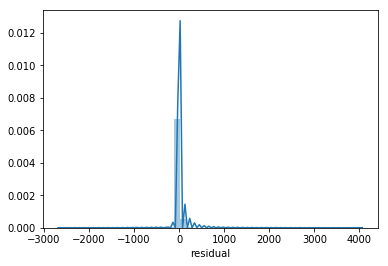

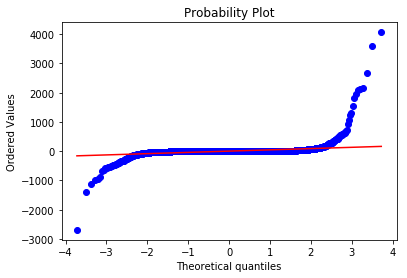

In [193]:
sku_dc_new_df = new_df.groupby(['ProductKey','RDCKey'])[['ypred_raw','salesForecast']].sum().reset_index()

print sku_dc_new_df.head()

print np.sum(np.abs(sku_dc_new_df.ypred_raw - sku_dc_new_df.salesForecast))/np.sum(sku_dc_new_df.salesForecast)

sku_dc_new_df.ProductKey.drop_duplicates().shape

sku_dc_new_df['residual'] = sku_dc_new_df.salesForecast - sku_dc_new_df.ypred_raw
sku_dc_new_df['residual_abs'] = np.abs(sku_dc_new_df.salesForecast - sku_dc_new_df.ypred_raw)

sns.distplot(sku_dc_new_df['residual']);
fig = plt.figure()
res = stats.probplot(sku_dc_new_df['residual'], plot=plt)

In [194]:
print("Skewness: %f" % sku_dc_new_df['residual'].skew())
print("Kurtosis: %f" % sku_dc_new_df['residual'].kurt())

Skewness: 14.084290
Kurtosis: 493.303795


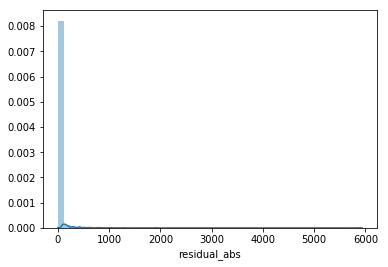

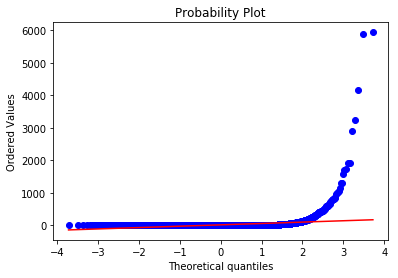

In [81]:
sns.distplot(sku_dc_new_df['residual_abs']);
fig = plt.figure()
res = stats.probplot(sku_dc_new_df['residual_abs'], plot=plt)

In [195]:
sku_new_df = new_df.groupby(['ProductKey'])[['ypred_raw','salesForecast']].sum().reset_index()

sku_new_df.head()

print np.sum(np.abs(sku_new_df.ypred_raw - sku_new_df.salesForecast))/np.sum(sku_new_df.salesForecast)

0.22747504830964954


In [196]:
print np.sum(np.abs(new_df.ypred_raw - new_df.salesForecast))/np.sum(new_df.salesForecast)

0.6013378221787343


In [197]:
update_cols = list(set(scenario['promo_feature_cols'])- set(exclu_promo_features))
need_cols = ['Date','RDCKey','ProductKey','HierarchyLevel3Key'] + update_cols
groupkeys = ['RDCKey','ProductKey','HierarchyLevel3Key']
reg_cols = []#['Holiday','Ind_1111_pre','Ind_1111','Ind_1111_post','Ind_618_pre','Ind_618','Ind_618_post','Ind_1212','Month','DayOfWeek',]


In [198]:
def predict_history_mean_and_raw(train_feature_df_new, reg_cols, listkeys, keys, model, update_cols, scenario):
    uses_promo = ['mean', 'no']
    df = train_feature_df_new
    for use_promo in uses_promo:
        if use_promo == 'mean':
            df1 = df[need_cols]
            promo_feature_cols = scenario['promo_feature_cols']
            df11 = df1.groupby(keys)[update_cols].mean().reset_index()
            df2 = pd.merge(df, df11[keys + update_cols], how='left', on=keys)

            rename_update_cols = [col + '_y' for col in update_cols]
            for col in update_cols:
                df2.rename(columns={col + '_y': col}, inplace=True)
                df2.drop(col + '_x', axis=1, inplace=True)
            grouped = df2.groupby('RDCKey')
        else:
            # histoty bottomup forecast
            grouped = df.groupby('RDCKey')
        result_list = []
        for rdc, history_df in grouped:
            if rdc in model.keys():
                this_model = model[rdc]
            else:
                continue
            ''' predict model '''
            xColumns = scenario['selectedColumns']['features']

            if 'RDCKey' in xColumns:  # 删除季节性,RDCKEY
                xColumns.remove('skuDecomposedTrend')
                xColumns.remove('skuDecomposedSeasonal')
                xColumns.remove('level3DecomposedTrend')
                xColumns.remove('level3DecomposedSeasonal')
                xColumns.remove('Curve')
                xColumns.remove('RDCKey')

            X_history = history_df[xColumns]

            history_xtest = xgb.DMatrix(X_history.values, missing=np.NaN)
            ypred = this_model.predict(history_xtest)
            history_df['ypred'] = ypred
            history_df['RDCKey'] = rdc

            ''' Tuning result '''
            lanjie = history_df[(history_df.ypred < 0)]
            if len(lanjie) > 0:
                history_df.ix[lanjie.index, 'ypred'] = 0
            result_list.append(history_df)
        final_result = pd.concat(result_list)
        if use_promo == 'no':
            raw_train_df = final_result[
                listkeys + reg_cols + scenario['promo_feature_cols'] + ['salesForecast', 'ypred']]
        else:
            # use_promo == 'mean':
            train_df_mean = final_result[
                listkeys + reg_cols + scenario['promo_feature_cols'] + ['salesForecast', 'ypred']]
            train_df_mean.rename(columns={'ypred': 'ypred_mean_promo'}, inplace=True)
    return raw_train_df, train_df_mean


raw_train_df, train_df_mean = predict_history_mean_and_raw(train_feature_df_new, reg_cols, list_keys, groupkeys, model,
                                                           update_cols, scenario)


/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [199]:
raw_train_df.shape

(2319750, 46)

In [200]:
train_df_mean.shape

(2319750, 46)

In [201]:
raw_train_df = pd.merge(raw_train_df, train_df_mean[list_keys+['ypred_mean_promo']], how='left', on=list_keys)

In [202]:
raw_train_df['residual'] = raw_train_df.ypred - raw_train_df.salesForecast

In [203]:
unitVolumeQuantile = raw_train_df.groupby(['RDCKey','ProductKey'])['residual'].quantile(0.97, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {'residual': 'UnitCapVolume_max'}, inplace=True)
raw_train_df= pd.merge(raw_train_df, quantileDf, how='left', on=['RDCKey','ProductKey'])
raw_train_df['OrderNonOutlierResidual'] = raw_train_df[['residual', 'UnitCapVolume_max']].min(axis=1)

unitVolumeQuantile = raw_train_df.groupby(['RDCKey','ProductKey'])['residual'].quantile(0.05, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {'residual': 'UnitCapVolume_min'}, inplace=True)
raw_train_df= pd.merge(raw_train_df, quantileDf, how='left', on=['RDCKey','ProductKey'])
raw_train_df['OrderNonOutlierResidual'] = raw_train_df[['residual', 'UnitCapVolume_min']].max(axis=1)

In [204]:
raw_train_df.head()

,Date,RDCKey,ProductKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,syntheticdiscounta_vb,durationinhours,daynumberinpromotion,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,residual,UnitCapVolume_max,OrderNonOutlierResidual,UnitCapVolume_min
0,2017-04-04,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,62.0,8.651570,8.651570,-53.348430,51.171204,-53.348430,-74.49295
1,2017-04-05,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,203.0,191.495575,239.474457,-11.504425,51.171204,-11.504425,-74.49295
2,2017-04-06,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,218.0,185.733780,195.298599,-32.266220,51.171204,-32.266220,-74.49295
3,2017-04-07,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,144.0,145.315430,154.880249,1.315430,51.171204,1.315430,-74.49295
4,2017-04-08,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,43.0,39.971214,60.321198,-3.028786,51.171204,-3.028786,-74.49295


In [205]:
resi_fut = new_df[(new_df.ProductKey==127768)&(new_df.RDCKey==3)]

In [206]:
resi_fut.head()

,Date,RDCKey,ProductKey,ypred_raw,dd_price_weighted,bd_price_weighted,dd_price_weighted_x,bd_price_weighted_x,SyntheticGrossPrice,ypred_mean_promo,salesForecast
0,2018-05-08,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,304.0
1,2018-05-09,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,217.0
2,2018-05-10,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,29.0
3,2018-05-11,3.0,127768,144.125168,150.279874,150.279874,171.0,171.0,NaN,130.575012,7.0
4,2018-05-12,3.0,127768,164.226593,150.279874,150.279874,171.0,171.0,NaN,151.275711,3.0


In [207]:
resi_fut = resi_fut[['Date','RDCKey','ProductKey','ypred_raw','salesForecast']]

In [208]:
resi_fut['residual'] = resi_fut.ypred_raw - resi_fut.salesForecast

In [209]:
resi_fut.head()

,Date,RDCKey,ProductKey,ypred_raw,salesForecast,residual
0,2018-05-08,3.0,127768,386.302582,304.0,82.302582
1,2018-05-09,3.0,127768,386.302582,217.0,169.302582
2,2018-05-10,3.0,127768,386.302582,29.0,357.302582
3,2018-05-11,3.0,127768,144.125168,7.0,137.125168
4,2018-05-12,3.0,127768,164.226593,3.0,161.226593


In [210]:
tmp_raw = raw_train_df[(raw_train_df.ProductKey==127768)&(raw_train_df.RDCKey==3)]

tmp_raw.tail()

tmp = raw_train_df[(raw_train_df.ProductKey==127768)&(raw_train_df.RDCKey==3)]

#tmp['residual'] = tmp.ypred - tmp.salesForecast

In [211]:
tmp.head()

,Date,RDCKey,ProductKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,syntheticdiscounta_vb,durationinhours,daynumberinpromotion,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,residual,UnitCapVolume_max,OrderNonOutlierResidual,UnitCapVolume_min
0,2017-04-04,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,62.0,8.651570,8.651570,-53.348430,51.171204,-53.348430,-74.49295
1,2017-04-05,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,203.0,191.495575,239.474457,-11.504425,51.171204,-11.504425,-74.49295
2,2017-04-06,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,218.0,185.733780,195.298599,-32.266220,51.171204,-32.266220,-74.49295
3,2017-04-07,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,144.0,145.315430,154.880249,1.315430,51.171204,1.315430,-74.49295
4,2017-04-08,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,43.0,39.971214,60.321198,-3.028786,51.171204,-3.028786,-74.49295


In [212]:
thres_min = tmp.residual.quantile(0.05, interpolation='lower')
thres_max = tmp.residual.quantile(0.97, interpolation='lower')
tmp = tmp[(tmp.residual>=thres_min)&(tmp.residual<=thres_max)]

In [136]:
tmp[['Date','residual']].set_index('Date').plot()

from pyramid.arima import auto_arima
from pyramid.arima.utils import ndiffs, diff
from pyramid.arima.utils import nsdiffs

tmp_test = tmp[['Date','RDCKey','ProductKey','residual']]
tmp_test.rename(columns={'Date':'ds',
                         'residual':'y'},inplace=True)


tmp_test

from fbprophet import Prophet
prophet = Prophet(changepoint_prior_scale=0.05, interval_width=0.9, mcmc_samples=729)

df_train = tmp_test[['ds','y']]
prophet.fit(df_train)

future = prophet.make_future_dataframe(freq='D', periods=7)
forecast = prophet.predict(future)


forecast

tmp_test.info()

df_result_arima = sarima_model(tmp_test, ['RDCKey','ProductKey'], pd.to_datetime('2018-05-08'), pre_len=91,types='day', zaixian=False)

tmp_test.y.mean()

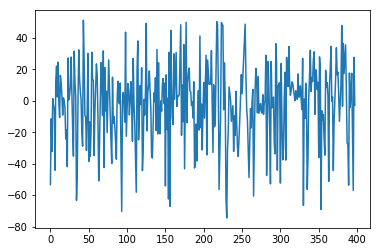

In [259]:
tmp.residual.plot()

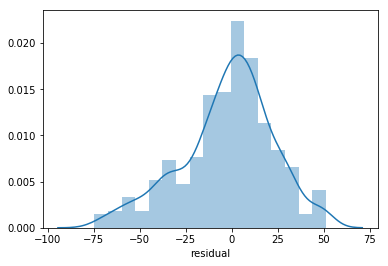

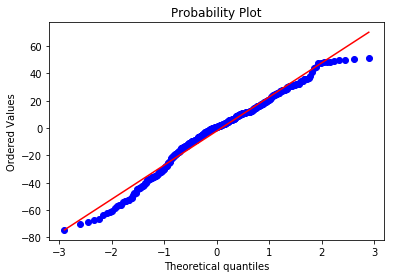

In [215]:
sns.distplot(tmp['residual']);
fig = plt.figure()
res = stats.probplot(tmp['residual'], plot=plt)

In [216]:
print("Skewness: %f" % tmp['OrderNonOutlierResidual'].skew())
print("Kurtosis: %f" % tmp['OrderNonOutlierResidual'].kurt())

Skewness: -0.461942
Kurtosis: 0.098953


In [219]:
raw_train_df.head()

,Date,RDCKey,ProductKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,syntheticdiscounta_vb,durationinhours,daynumberinpromotion,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,residual,UnitCapVolume_max,OrderNonOutlierResidual,UnitCapVolume_min
0,2017-04-04,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,62.0,8.651570,8.651570,-53.348430,51.171204,-53.348430,-74.49295
1,2017-04-05,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,203.0,191.495575,239.474457,-11.504425,51.171204,-11.504425,-74.49295
2,2017-04-06,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,218.0,185.733780,195.298599,-32.266220,51.171204,-32.266220,-74.49295
3,2017-04-07,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,144.0,145.315430,154.880249,1.315430,51.171204,1.315430,-74.49295
4,2017-04-08,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,43.0,39.971214,60.321198,-3.028786,51.171204,-3.028786,-74.49295


In [311]:
test_df = raw_train_df[['Date','RDCKey','ProductKey','OrderNonOutlierResidual']]
test_df['categoryname'] = list(map(lambda x ,y: str(x)+'#'+str(y),test_df['RDCKey'],test_df['ProductKey']))

print test_df.tail()

#test_df.drop(['RDCKey','ProductKey'],axis=1,inplace=True)
print test_df.head()

              Date  RDCKey ProductKey  OrderNonOutlierResidual categoryname
2319745 2018-05-03     772    7304425                 0.323850  772#7304425
2319746 2018-05-04     772    7304425                 0.262939  772#7304425
2319747 2018-05-05     772    7304425                -1.814032  772#7304425
2319748 2018-05-06     772    7304425                 0.229521  772#7304425
2319749 2018-05-07     772    7304425                 0.203705  772#7304425
        Date  RDCKey ProductKey  OrderNonOutlierResidual categoryname
0 2017-04-04       3     127768               -53.348430     3#127768
1 2017-04-05       3     127768               -11.504425     3#127768
2 2017-04-06       3     127768               -32.266220     3#127768
3 2017-04-07       3     127768                 1.315430     3#127768
4 2017-04-08       3     127768                -3.028786     3#127768


/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [334]:
demo_df_week.head()

,weekofyear,year,categoryname,RDCKey,ProductKey,y,ds
0,1,2018,10#1003583,10,1003583,-1.301004,1#2018
1,1,2018,10#1003584,10,1003584,5.322445,1#2018
2,1,2018,10#1003589,10,1003589,-24.145788,1#2018
3,1,2018,10#1003595,10,1003595,4.275733,1#2018
4,1,2018,10#1003599,10,1003599,-6.667593,1#2018


In [312]:
#demo_df = test_df[test_df.categoryname == '3#127768']

test_df['weekofyear'] = test_df.Date.apply(lambda x: x.isocalendar()[1])
test_df['year'] = test_df.Date.dt.year

test_df.tail()

demo_df_week = test_df.groupby(['weekofyear','year','categoryname','RDCKey','ProductKey'])['OrderNonOutlierResidual'].sum().reset_index()

print test_df.head()
print test_df.shape

demo_df_week['ds'] = list(map(lambda x ,y: str(x)+'#'+str(y),demo_df_week['weekofyear'],demo_df_week['year']))
demo_df_week.rename(columns={'OrderNonOutlierResidual':'y'},inplace=True)

demo_df_week.head()

df_train_all = demo_df_week

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


        Date  RDCKey ProductKey  OrderNonOutlierResidual categoryname  \
0 2017-04-04       3     127768               -53.348430     3#127768   
1 2017-04-05       3     127768               -11.504425     3#127768   
2 2017-04-06       3     127768               -32.266220     3#127768   
3 2017-04-07       3     127768                 1.315430     3#127768   
4 2017-04-08       3     127768                -3.028786     3#127768   

   weekofyear  year  
0          14  2017  
1          14  2017  
2          14  2017  
3          14  2017  
4          14  2017  
(2319750, 7)


/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [314]:
sku_demo_df = demo_df_week[demo_df_week.ProductKey==127768]

In [319]:
sku_demo_df.RDCKey.unique()

array([ 10,   3, 316,   4,   5,   6, 772,   9])

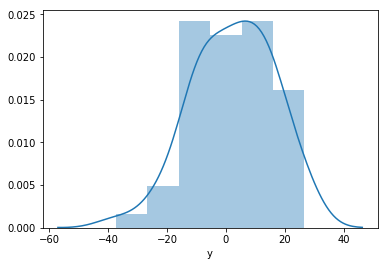

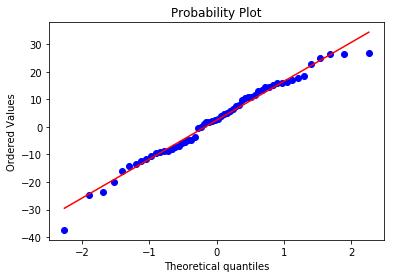

In [327]:
tmp = sku_demo_df[sku_demo_df.RDCKey==772]
sns.distplot(tmp.y);
fig = plt.figure()
res = stats.probplot(tmp.y, plot=plt)

In [329]:
df_train_all.head()

,weekofyear,year,categoryname,RDCKey,ProductKey,y,ds
0,1,2018,10#1003583,10,1003583,-1.301004,1#2018
1,1,2018,10#1003584,10,1003584,5.322445,1#2018
2,1,2018,10#1003589,10,1003589,-24.145788,1#2018
3,1,2018,10#1003595,10,1003595,4.275733,1#2018
4,1,2018,10#1003599,10,1003599,-6.667593,1#2018


In [332]:
range(13)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [347]:
#demo_df = demo_df_week[demo_df_week.categoryname == '3#127768']
df_tmp_all = []
pre_len = 13
a = 1
for key,group in df_train_all.groupby('categoryname'):
    tmp_result = pd.DataFrame()
    df_group = group[['ds', 'y']].reset_index(drop=True)
    D_f = nsdiffs(df_group['y'], m=3, max_D=5, test='ch')
    d_f = ndiffs(df_group['y'], alpha=0.05, test='kpss', max_d=5)
    if df_group.shape[0] >= 30 and a <= 300:
        stepwise_fit = auto_arima(df_group['y'], start_p=0, start_q=0, max_p=3, max_q=3, m=12,
                                  start_P=0, seasonal=True, d=d_f, D=D_f, trace=True,
                                  error_action='ignore',  # don't want to know if an order does not work
                                  suppress_warnings=True,  # don't want convergence warnings
                                  stepwise=True)  # set to stepwise
        a += 1
    else:
        continue
    
    output = stepwise_fit.predict(n_periods=pre_len)
    tmp_result['categoryname'] = np.repeat(key, pre_len)
    tmp_result['yhat'] = output
    tmp_result['pre_period'] = range(13)
    df_tmp_all.append(tmp_result)
result_df = pd.concat(df_tmp_all)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=369.278, BIC=375.460, Fit time=0.119 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=370.606, BIC=378.848, Fit time=0.207 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=370.327, BIC=378.568, Fit time=0.178 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=371.222, BIC=379.463, Fit time=0.245 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=370.462, BIC=378.704, Fit time=0.198 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=369.085, BIC=379.387, Fit time=0.484 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=370.944, BIC=38

Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=243.015, BIC=251.257, Fit time=0.486 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=244.962, BIC=255.264, Fit time=0.601 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=243.641, BIC=249.822, Fit time=0.138 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=245.015, BIC=255.317, Fit time=0.562 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=245.015, BIC=255.318, Fit time=0.535 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.509 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=558.086, BIC=564.268, Fit time=0.105 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 

Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=654.744, BIC=665.046, Fit time=0.208 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=655.923, BIC=668.286, Fit time=0.494 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 1, 12); AIC=655.941, BIC=668.303, Fit time=0.498 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=657.905, BIC=672.328, Fit time=0.616 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=653.258, BIC=661.500, Fit time=0.155 seconds
Fit ARIMA: order=(0, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=654.894, BIC=665.196, Fit time=0.272 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=656.168, BIC=668.531, Fit time=0.405 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=653.927, BIC=664.230, Fit time=0.276 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 1, 12);

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=515.488, BIC=523.730, Fit time=0.199 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.032 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=446.741, BIC=452.923, Fit time=0.109 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=446.735, BIC=454.977, Fit time=0.192 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=446.416, BIC=454.658, Fit time=0.164 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=448.415, BIC=458.717, Fit time=0.398 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=446.299, BIC=452.481, Fit time=0.126 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=448.274, BIC=456.515, Fit time=0.087 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=524.638, BIC=537.001, Fit time=0.646 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=523.901, BIC=532.142, Fit time=0.285 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=523.898, BIC=536.261, Fit time=0.597 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=525.934, BIC=540.357, Fit time=0.800 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=521.214, BIC=533.577, Fit time=3.377 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 0, 12); AIC=522.337, BIC=532.639, Fit time=1.406 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=520.595, BIC=535.018, Fit time=4.543 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=521.486, BIC=533.848, Fit time=4.984 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 1, 12); AIC=522.431, BIC=538.915, Fit time=2.544 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 

Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 1, 12); AIC=286.520, BIC=296.822, Fit time=0.227 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 1, 12); AIC=288.153, BIC=300.516, Fit time=0.725 seconds
Total fit time: 1.825 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=181.494, BIC=187.675, Fit time=0.069 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=182.972, BIC=191.214, Fit time=0.110 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=183.460, BIC=191.702, Fit time=0.092 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=182.420, BIC=190.661, Fit time=0.219 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 

Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=91.795, BIC=100.037, Fit time=0.230 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=92.801, BIC=101.043, Fit time=0.922 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=92.086, BIC=100.328, Fit time=0.229 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=93.760, BIC=104.062, Fit time=0.666 seconds
Total fit time: 2.410 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=122.315, BIC=128.497, Fit time=0.219 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=123.479, BIC=131.721, Fit time=0.278 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1

Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=21.025, BIC=29.267, Fit time=0.170 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=20.492, BIC=28.734, Fit time=0.263 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=22.328, BIC=32.630, Fit time=0.272 seconds
Total fit time: 1.439 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=398.406, BIC=404.587, Fit time=0.273 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=398.433, BIC=406.675, Fit time=0.703 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=398.440, BIC=406.682, Fit time=0.212 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=400.401, BIC=408.642, Fit time=0.611 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=445.200, BIC=453.442, Fit time=0.672 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=444.740, BIC=452.982, Fit time=0.331 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=445.945, BIC=456.247, Fit time=0.609 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=442.743, BIC=448.924, Fit time=0.208 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=442.463, BIC=450.705, Fit time=0.288 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=443.220, BIC=449.401, Fit time=0.071 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=444.459, BIC=454.761, Fit time=0.756 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=444.4

Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=506.980, BIC=519.343, Fit time=0.421 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=509.115, BIC=523.538, Fit time=2.181 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=505.678, BIC=518.040, Fit time=0.441 seconds
Total fit time: 10.301 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=496.803, BIC=502.985, Fit time=0.183 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=498.165, BIC=506.407, Fit time=0.232 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=498.743, BIC=506.985, Fit time=0.284 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1,

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=430.310, BIC=438.551, Fit time=0.185 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=430.291, BIC=438.533, Fit time=0.296 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=429.689, BIC=437.930, Fit time=0.528 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=430.420, BIC=438.661, Fit time=0.580 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=428.809, BIC=439.111, Fit time=0.355 seconds
Total fit time: 2.045 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=483.553, BIC=489.734, Fit time=0.143 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=283.018, BIC=291.260, Fit time=0.175 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=282.825, BIC=291.067, Fit time=0.190 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=283.103, BIC=291.344, Fit time=0.231 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=282.924, BIC=291.166, Fit time=0.191 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=285.128, BIC=295.430, Fit time=0.303 seconds
Total fit time: 1.174 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=317.501, BIC=323.682, Fit time=0.082 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 

Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=20.709, BIC=28.951, Fit time=0.157 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=20.589, BIC=28.831, Fit time=0.225 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=22.353, BIC=32.655, Fit time=0.255 seconds
Total fit time: 1.130 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=451.691, BIC=457.873, Fit time=0.168 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=453.638, BIC=461.880, Fit time=0.228 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=453.600, BIC=461.842, Fit time=0.209 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=453.691, BIC=461.933, Fit time=0.280 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=

Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=231.314, BIC=243.676, Fit time=0.772 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(1, 0, 1, 12); AIC=232.448, BIC=248.931, Fit time=1.259 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 1, 12); AIC=232.107, BIC=242.409, Fit time=0.214 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(2, 0, 1, 12); AIC=232.690, BIC=247.113, Fit time=2.731 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=232.560, BIC=242.862, Fit time=0.248 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=231.422, BIC=239.664, Fit time=0.158 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=229.766, BIC=244.189, Fit time=1.045 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 0, 1, 12); AIC=234.4

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=134.941, BIC=143.183, Fit time=0.217 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=134.907, BIC=143.149, Fit time=0.101 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=135.209, BIC=143.451, Fit time=0.859 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=134.946, BIC=143.188, Fit time=0.154 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=132.329, BIC=142.631, Fit time=0.790 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=136.429, BIC=148.792, Fit time=0.840 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=130.365, BIC=138.607, Fit time=0.294 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=132.9

Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=21.272, BIC=29.514, Fit time=0.124 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=21.131, BIC=29.373, Fit time=0.270 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=23.131, BIC=33.433, Fit time=0.321 seconds
Total fit time: 1.169 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=185.177, BIC=191.358, Fit time=0.134 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=186.179, BIC=194.421, Fit time=0.213 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=186.186, BIC=194.427, Fit time=0.194 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=186.736, BIC=194.978, Fit time=0.365 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=256.856, BIC=265.098, Fit time=0.206 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=256.858, BIC=265.100, Fit time=0.165 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=257.122, BIC=265.364, Fit time=0.208 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=256.849, BIC=265.091, Fit time=0.185 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=256.243, BIC=266.545, Fit time=0.240 seconds
Total fit time: 1.110 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=398.846, BIC=405.027, Fit time=0.097 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 

Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=306.204, BIC=320.627, Fit time=0.452 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 4.514 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=409.266, BIC=415.448, Fit time=0.065 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=410.136, BIC=418.378, Fit time=0.215 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=409.227, BIC=417.468, Fit time=0.176 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=408.045, BIC=418.347, Fit time=0.530 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=409.276, BIC=417.518, Fit time=0.199 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=435.758, BIC=444.000, Fit time=0.146 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=435.659, BIC=443.900, Fit time=0.110 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=434.208, BIC=442.449, Fit time=0.204 seconds
Total fit time: 1.293 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=204.852, BIC=211.034, Fit time=0.085 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=205.755, BIC=213.997, Fit time=0.195 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=205.664, BIC=213.905, Fit time=0.095 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=206.172, BIC=214.414, Fit time=0.343 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=494.696, BIC=502.937, Fit time=0.215 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=494.695, BIC=502.937, Fit time=0.232 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=494.081, BIC=502.323, Fit time=0.628 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=494.693, BIC=502.935, Fit time=0.208 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=496.693, BIC=506.995, Fit time=0.380 seconds
Total fit time: 1.839 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=428.670, BIC=434.851, Fit time=0.205 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=399.219, BIC=405.400, Fit time=0.102 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=401.215, BIC=409.457, Fit time=0.161 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=403.029, BIC=413.331, Fit time=0.688 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=399.115, BIC=407.357, Fit time=0.069 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=401.042, BIC=411.345, Fit time=0.134 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=399.704, BIC=412.067, Fit time=0.365 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=401.098, BIC=411.400, Fit time=0.275 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=401.099, BIC=411.402, Fit time=0.228 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=402.816, BIC=415.179, Fit time=0.378 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=45.122, BIC=51.304, Fit time=0.056 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=46.805, BIC=55.047, Fit time=0.104 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=46.682, BIC=54.924, Fit time=0.178 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=48.599, BIC=58.901, Fit time=0.205 seconds
Total fit time: 0.724 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=47.086, BIC=55.327, Fit time=0.193 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, 

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=21.579, BIC=29.820, Fit time=0.321 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=19.640, BIC=25.821, Fit time=0.080 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=20.991, BIC=29.233, Fit time=0.078 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=20.701, BIC=28.943, Fit time=0.212 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=22.496, BIC=32.798, Fit time=0.228 seconds
Total fit time: 0.959 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=246.332, BIC=252.513, Fit time=0.145 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12);

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=21.599, BIC=29.841, Fit time=0.072 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=22.533, BIC=32.835, Fit time=0.214 seconds
Total fit time: 0.704 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=753.266, BIC=759.447, Fit time=0.086 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=755.262, BIC=763.503, Fit time=0.339 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=755.260, BIC=763.502, Fit time=0.234 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=755.266, BIC=763.508, Fit time=0.116 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=86.669, BIC=94.910, Fit time=0.455 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=81.382, BIC=91.684, Fit time=0.637 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=79.775, BIC=88.017, Fit time=0.263 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=84.148, BIC=90.329, Fit time=0.132 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=85.102, BIC=91.283, Fit time=0.049 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=74.693, BIC=84.995, Fit time=0.172 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=74.185, BIC=88.609, Fit time=0.458 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 0, 0, 12); AIC=76.177, BIC=92.661,

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=348.207, BIC=356.449, Fit time=0.593 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.041 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=508.658, BIC=514.839, Fit time=0.454 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=510.506, BIC=518.748, Fit time=0.584 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=509.958, BIC=518.200, Fit time=0.164 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=510.452, BIC=518.693, Fit time=0.733 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=499.758, BIC=508.000, Fit time=0.223 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=469.262, BIC=477.504, Fit time=0.285 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=470.685, BIC=480.988, Fit time=0.392 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=472.257, BIC=478.438, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.177 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=298.7

Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=271.743, BIC=284.106, Fit time=0.865 seconds
Total fit time: 7.897 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=293.278, BIC=299.459, Fit time=0.141 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=295.163, BIC=303.404, Fit time=0.165 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=295.093, BIC=303.335, Fit time=0.116 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=294.927, BIC=303.169, Fit time=0.374 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=295.134, BIC=303.376, Fit time=0.153 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 

Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=545.414, BIC=553.656, Fit time=0.299 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=547.369, BIC=557.671, Fit time=0.943 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=543.432, BIC=549.613, Fit time=0.064 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=545.406, BIC=553.648, Fit time=0.122 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=545.355, BIC=553.597, Fit time=0.171 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=546.577, BIC=556.879, Fit time=0.261 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=545.411, BIC=553.653, Fit time=0.265 seconds
Total fit time: 2.940 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=691.008, BIC=697.189, Fit time=0.205 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0)

Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=316.589, BIC=326.892, Fit time=0.945 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=318.441, BIC=330.803, Fit time=0.814 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=314.799, BIC=325.101, Fit time=1.695 seconds
Total fit time: 5.611 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=627.766, BIC=633.947, Fit time=0.098 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=621.894, BIC=630.136, Fit time=0.321 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=620.674, BIC=628.915, Fit time=0.321 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=620.598, BIC=630.900, Fit time=0.482 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=620.674, BIC=628.915, Fit time=0.369 seconds
Fit ARIMA: order=(0, 0, 1)

Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=678.505, BIC=686.747, Fit time=0.317 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=679.957, BIC=688.198, Fit time=0.233 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=678.880, BIC=687.121, Fit time=0.297 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=674.005, BIC=684.307, Fit time=0.513 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=682.424, BIC=694.786, Fit time=0.698 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=680.089, BIC=688.331, Fit time=0.174 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, F

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=355.150, BIC=363.391, Fit time=0.229 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=354.752, BIC=362.994, Fit time=0.219 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=355.988, BIC=364.229, Fit time=0.307 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=355.147, BIC=363.389, Fit time=0.230 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=356.290, BIC=366.592, Fit time=0.292 seconds
Total fit time: 1.356 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=315.787, BIC=321.968, Fit time=0.161 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=481.182, BIC=489.424, Fit time=0.495 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=482.984, BIC=491.226, Fit time=0.197 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.308 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=386.796, BIC=392.978, Fit time=0.165 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=385.908, BIC=394.150, Fit time=0.244 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=385.632, BIC=393.874, Fit time=0.237 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12);

Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=539.192, BIC=547.434, Fit time=0.656 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=540.154, BIC=550.456, Fit time=0.574 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=537.248, BIC=543.430, Fit time=0.182 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=539.100, BIC=547.341, Fit time=0.144 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=539.137, BIC=547.379, Fit time=0.190 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=541.097, BIC=551.399, Fit time=0.263 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=539.197, BIC=547.439, Fit time=0.257 seconds
Total fit time: 2.801 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=632.040, BIC=638.222, Fit time=0.163 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0)

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=312.546, BIC=320.788, Fit time=0.202 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=312.120, BIC=322.422, Fit time=0.780 seconds
Total fit time: 2.483 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=352.050, BIC=358.232, Fit time=0.087 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=353.973, BIC=362.215, Fit time=0.176 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=353.953, BIC=362.195, Fit time=0.156 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=353.841, BIC=362.083, Fit time=0.203 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=331.200, BIC=337.382, Fit time=0.553 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=nan, BIC=nan, Fit time=0.702 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=333.102, BIC=341.344, Fit time=0.173 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 12); AIC=326.539, BIC=338.901, Fit time=2.388 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=326.900, BIC=339.263, Fit time=0.787 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=328.536, BIC=342.959, Fit time=1.816 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 12.767 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=281.746, BIC=287.927, Fit time=0.144 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(

Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=20.991, BIC=29.233, Fit time=0.091 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=20.702, BIC=28.943, Fit time=0.244 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=22.496, BIC=32.798, Fit time=0.214 seconds
Total fit time: 1.058 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=425.791, BIC=431.973, Fit time=0.081 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=427.437, BIC=435.678, Fit time=0.220 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=427.645, BIC=435.887, Fit time=0.221 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=424.682, BIC=432.924, Fit time=0.580 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=425.446, BIC=431.627, Fit time=0.230 seconds
Fit ARIMA: order=(0, 0, 0) seaso

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=414.404, BIC=424.706, Fit time=1.098 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=411.179, BIC=417.360, Fit time=0.158 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=413.110, BIC=421.352, Fit time=0.216 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=414.396, BIC=424.699, Fit time=0.189 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 12); AIC=413.017, BIC=421.258, Fit time=0.264 seconds
Total fit time: 3.205 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=703.666, BIC=709.847, Fit time=0.067 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=701.012, BIC=709.254, Fit time=0.251 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_

Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=360.239, BIC=370.541, Fit time=0.196 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=358.202, BIC=366.444, Fit time=0.272 seconds
Total fit time: 2.235 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=339.470, BIC=345.651, Fit time=0.165 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=337.449, BIC=345.691, Fit time=0.261 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=336.940, BIC=345.182, Fit time=0.236 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=338.228, BIC=348.530, Fit time=0.469 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=335.262, BIC=341.443, Fit time=0.172 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=332.112, BIC=340.354, Fit time=0.290 seconds
Fit ARIMA: order=(1, 0, 0)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=443.772, BIC=452.013, Fit time=0.877 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=444.339, BIC=452.581, Fit time=0.250 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=445.530, BIC=455.832, Fit time=0.422 seconds
Total fit time: 2.485 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=248.821, BIC=255.003, Fit time=0.193 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=250.298, BIC=258.540, Fit time=0.274 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=250.154, BIC=258.395, Fit time=0.198 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 

Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=407.191, BIC=413.372, Fit time=0.117 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.627 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=129.276, BIC=135.457, Fit time=0.119 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=130.944, BIC=139.186, Fit time=0.190 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=130.981, BIC=139.222, Fit time=0.258 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=130.432, BIC=138.673, Fit time=0.525 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12);

Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=388.785, BIC=399.087, Fit time=0.339 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=384.988, BIC=391.169, Fit time=0.142 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=384.611, BIC=392.853, Fit time=0.252 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=387.213, BIC=393.394, Fit time=0.125 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=384.244, BIC=394.547, Fit time=0.190 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=0.100 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=386.159, BIC=398.522, Fit time=0.426 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 1, 12); AIC=386.169, BIC=398.532, Fit time=0.487 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=387.952, BIC=402.375, Fit time=0.764 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 12

Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=522.741, BIC=533.043, Fit time=0.321 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=522.155, BIC=530.396, Fit time=0.248 seconds
Total fit time: 2.196 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=352.098, BIC=358.279, Fit time=0.160 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=335.465, BIC=343.707, Fit time=0.239 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=316.360, BIC=324.602, Fit time=0.337 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=318.148, BIC=328.450, Fit time=0.581 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=316.615, BIC=322.796, Fit time=0.204 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_

NameError: name 'df_tmp_allll_all_allp_all' is not defined

In [349]:
result_df = pd.concat(df_tmp_all)

In [350]:
result_df.head()

,categoryname,yhat,pre_period
0,10#1003583,-0.067034,0
1,10#1003583,-0.236242,1
2,10#1003583,-0.373871,2
3,10#1003583,-0.485813,3
4,10#1003583,-0.576864,4


In [353]:
sku_dc_new_df.RDCKey = sku_dc_new_df.RDCKey.astype(int)
sku_dc_new_df['categoryname'] = list(map(lambda x ,y: str(x)+'#'+str(y),sku_dc_new_df['RDCKey'],sku_dc_new_df['ProductKey']))

In [354]:
sku_dc_new_df.head()

,ProductKey,RDCKey,ypred_raw,salesForecast,residual,residual_abs,categoryname
0,127768,3,1994.859619,588.0,-1406.859619,1406.859619,3#127768
1,127768,4,277.974762,277.0,-0.974762,0.974762,4#127768
2,127768,5,138.548416,118.0,-20.548416,20.548416,5#127768
3,127768,6,552.803284,10.0,-542.803284,542.803284,6#127768
4,127768,9,78.010506,242.0,163.989494,163.989494,9#127768


In [360]:
sku_dc_df_with_resihat = pd.merge(sku_dc_new_df, result_df[result_df.pre_period==0], how='left', on='categoryname')

In [362]:
resihat_df = sku_dc_df_with_resihat[~sku_dc_df_with_resihat.yhat.isnull()]

In [363]:
resihat_df.head()

,ProductKey,RDCKey,ypred_raw,salesForecast,residual,residual_abs,categoryname,yhat,pre_period
5,127768,10,995.159790,895.0,-100.159790,100.159790,10#127768,-24.520149,0.0
13,163890,10,5.656635,0.0,-5.656635,5.656635,10#163890,1.310867,0.0
21,189018,10,2.539208,0.0,-2.539208,2.539208,10#189018,-2.595966,0.0
29,189019,10,1.995671,3.0,1.004329,1.004329,10#189019,-0.346961,0.0
1909,1003583,10,15.648218,6.0,-9.648218,9.648218,10#1003583,-0.067034,0.0


In [367]:
resihat_df.yhat.sum()

-682.4299676935261

In [364]:
resihat_df['ypred_new'] = resihat_df.ypred_raw + resihat_df.yhat

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [366]:
print resihat_df.ypred_new.sum()
print resihat_df.ypred_raw.sum()
print resihat_df.salesForecast.sum()

print np.sum(np.abs(resihat_df.ypred_new - resihat_df.salesForecast)) / np.sum(resihat_df.salesForecast)
print np.sum(np.abs(resihat_df.ypred_raw - resihat_df.salesForecast)) / np.sum(resihat_df.salesForecast)

45897.48402328089
46579.914
56250.0
0.29864129972829795
0.29463627742555404


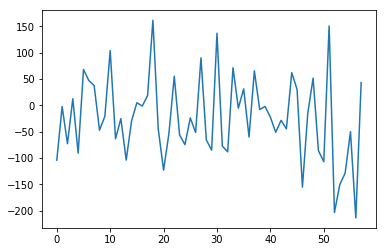

In [275]:
demo_df_week.OrderNonOutlierResidual.plot()

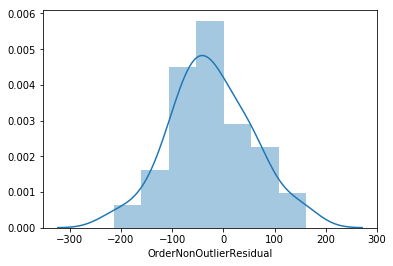

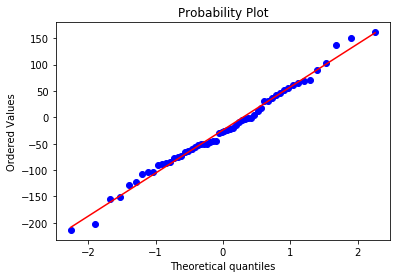

In [276]:
sns.distplot(demo_df_week.OrderNonOutlierResidual);
fig = plt.figure()
res = stats.probplot(demo_df_week.OrderNonOutlierResidual, plot=plt)

In [277]:
print("Skewness: %f" % demo_df_week['OrderNonOutlierResidual'].skew())
print("Kurtosis: %f" % demo_df_week['OrderNonOutlierResidual'].kurt())

Skewness: 0.089154
Kurtosis: 0.124878


In [278]:
demo_df_week.head()

,weekofyear,year,categoryname,OrderNonOutlierResidual
0,1,2018,3#127768,-103.904118
1,2,2018,3#127768,-2.338177
2,3,2018,3#127768,-72.731194
3,4,2018,3#127768,12.540386
4,5,2018,3#127768,-90.615940


In [ ]:
df_result_arima = sarima_model(tmp_test, [], pd.to_datetime('2018-05-08'), pre_len=7,types='day', zaixian=False)

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [55]:
unitVolumeQuantile = raw_train_df.groupby(['RDCKey','ProductKey'])['residual'].quantile(0.90, interpolation='lower')

quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()

quantileDf.rename(columns = {'residual': 'UnitCapVolume'}, inplace=True)

quantileDf.head()

raw_df= pd.merge(raw_train_df, quantileDf, how='left', on=['RDCKey','ProductKey'])

raw_df['OrderNonOutlierResidual'] = raw_df[['residual', 'UnitCapVolume']].min(axis=1)

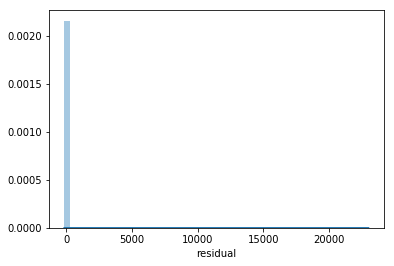

In [61]:
sns.distplot(raw_df['residual']);

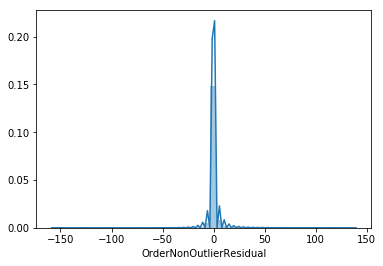

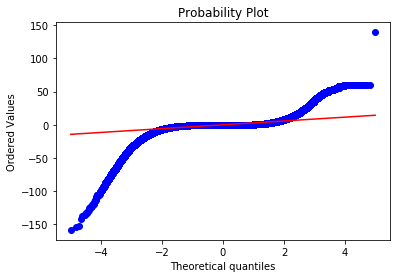

In [62]:
sns.distplot(raw_df['OrderNonOutlierResidual']);
fig = plt.figure()
res = stats.probplot(raw_df['OrderNonOutlierResidual'], plot=plt)

In [63]:
print("Skewness: %f" % raw_df['OrderNonOutlierResidual'].skew())
print("Kurtosis: %f" % raw_df['OrderNonOutlierResidual'].kurt())

Skewness: -1.040299
Kurtosis: 83.331588


In [83]:
threshold_mim = 1 - raw_df.OrderNonOutlierResidual.min()

In [84]:
raw_df['resi_new'] = raw_df.OrderNonOutlierResidual + threshold_mim

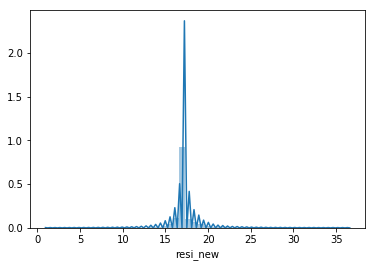

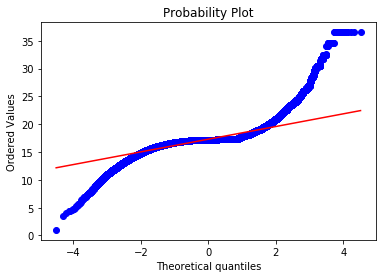

In [85]:
sns.distplot(raw_df['resi_new']);
fig = plt.figure()
res = stats.probplot(raw_df['resi_new'], plot=plt)

In [86]:
raw_df["log_resi"] = np.log1p(raw_df["resi_new"])


 mu = 2.91 and sigma = 0.07



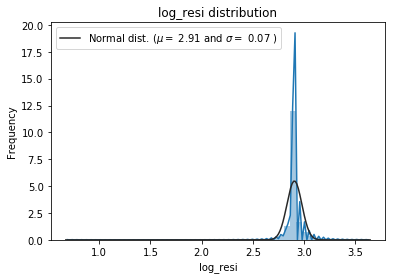

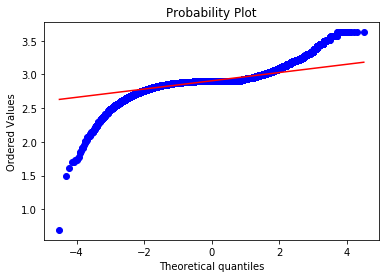

In [87]:
sns.distplot(raw_df["log_resi"] , fit=norm);

(mu, sigma) = norm.fit(raw_df["log_resi"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log_resi distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(raw_df["log_resi"], plot=plt)
plt.show()

In [89]:
from scipy.special import boxcox1p
lam = 0.15
raw_df['bc_resi'] = boxcox1p(raw_df['resi_new'], lam)


 mu = 3.64 and sigma = 0.11



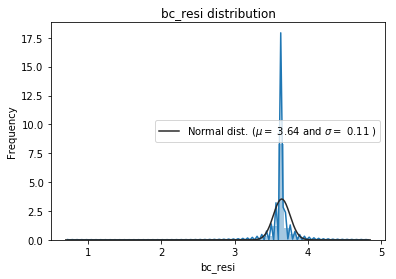

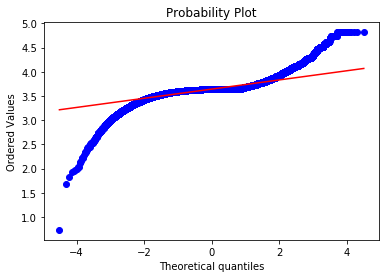

In [90]:
sns.distplot(raw_df["bc_resi"] , fit=norm);

(mu, sigma) = norm.fit(raw_df["bc_resi"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('bc_resi distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(raw_df["bc_resi"], plot=plt)
plt.show()

In [ ]:
print("Skewness: %f" % raw_df['OrderNonOutlierResidual'].skew())
print("Kurtosis: %f" % raw_df['OrderNonOutlierResidual'].kurt())

In [64]:
raw_df_na = (raw_df.isnull().sum() / len(raw_df)) * 100

raw_df_na = raw_df_na.drop(raw_df_na[raw_df_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' :raw_df_na})

missing_data.head(20)

Text(0.5,1,'Percent missing data by feature')

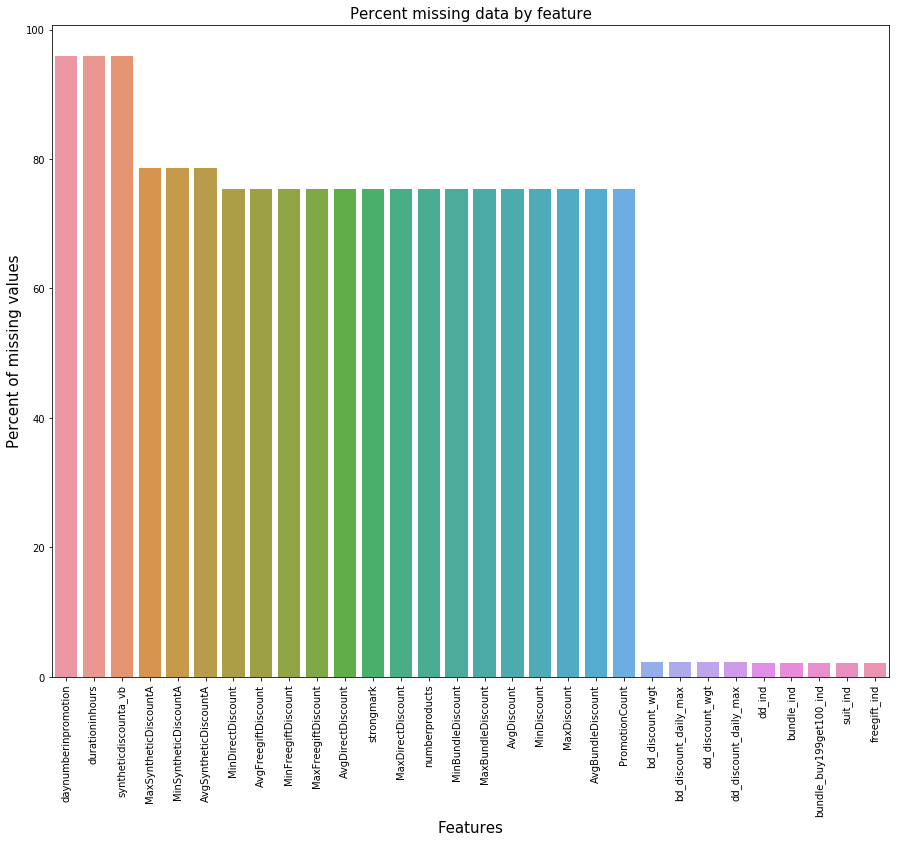

In [68]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=raw_df_na.index, y=raw_df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [69]:
raw_df[raw_df.daynumberinpromotion.isnull()].head()

,Date,RDCKey,ProductKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,syntheticdiscounta_vb,durationinhours,daynumberinpromotion,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,residual,UnitCapVolume,OrderNonOutlierResidual
0,2017-04-04,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,62.0,125.854378,151.185898,-63.854378,44.679794,-63.854378
1,2017-04-05,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,203.0,227.239532,252.571075,-24.239532,44.679794,-24.239532
2,2017-04-06,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,218.0,193.567047,231.400635,24.432953,44.679794,24.432953
3,2017-04-07,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,144.0,167.791809,154.428619,-23.791809,44.679794,-23.791809
4,2017-04-08,3,127768,1.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,0.0,0.0,0.0,0.128655,0.128655,0.128655,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,149.0,149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.128655,0.128655,0.0,149.0,149.0,171.0,149.0,0.1287,0.0,0.1287,0.0,43.0,35.932953,35.169029,7.067047,44.679794,7.067047


In [106]:
raw_df.mode()

,Date,RDCKey,ProductKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,syntheticdiscounta_vb,durationinhours,daynumberinpromotion,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,residual,UnitCapVolume,OrderNonOutlierResidual,resi_new,log_resi,bc_resi
0,2018-01-31,3.0,255778.0,1.0,0.5,0.050505,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,24.0,1.0,1.0,0.0,98.0,98.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,98.0,98.0,98.0,98.0,0.0,-0.0,0.0,-0.0,0.0,0.008502,0.006561,-0.008502,-0.003956,-0.008502,17.263368,2.904897,3.640656
1,NaT,NaN,255780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,333373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,333374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,720003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaT,NaN,981759.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaT,NaN,1060162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaT,NaN,1060340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaT,NaN,1071533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaT,NaN,1126204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
new_raw_df = raw_df.drop(['daynumberinpromotion','durationinhours','syntheticdiscounta_vb','UnitCapVolume','residual',\
                          'OrderNonOutlierResidual'],axis=1)

In [113]:
new_raw_df.head()

,Date,RDCKey,ProductKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,resi_new,log_resi,bc_resi
0,2016-12-29,3.0,255778,2.0,0.172619,0.053571,0.113095,0.1258,0.0000,0.0629,0.0,0.0,0.0,0.172619,0.053571,0.113095,0.0,0.0,0.0,1.0,0.0,152.3333,152.3333,1.0,3.0,2.0,0.0,0.0,0.0,2.0,0.172619,0.172619,0.0,139.0,139.0,168.0,159.0,0.0933,0.0419,0.0933,0.0419,10.0,7.277032,4.851426,19.994837,3.044277,3.858418
1,2016-12-30,3.0,255778,2.0,0.172619,0.053571,0.113095,0.1258,0.0000,0.0629,0.0,0.0,0.0,0.172619,0.053571,0.113095,0.0,0.0,0.0,1.0,0.0,142.5125,142.5125,1.0,3.0,2.0,0.0,0.0,0.0,2.0,0.172619,0.172619,0.0,139.0,139.0,168.0,159.0,0.1517,0.1037,0.1517,0.1037,2.0,5.525453,4.535577,13.746417,2.691000,3.315199
2,2016-12-31,3.0,255778,1.0,0.053571,0.053571,0.053571,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.053571,0.053571,0.053571,0.0,0.0,0.0,1.0,0.0,159.0001,159.0001,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.053571,0.053571,0.0,159.0,159.0,168.0,159.0,0.0536,-0.0000,0.0536,-0.0000,3.0,7.265825,6.632557,13.006044,2.639489,3.238370
3,2017-01-01,3.0,255778,1.0,0.017857,0.017857,0.017857,-0.0377,-0.0377,-0.0377,0.0,0.0,0.0,0.017857,0.017857,0.017857,0.0,0.0,0.0,1.0,0.0,165.0000,165.0000,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.017857,0.017857,0.0,165.0,165.0,168.0,159.0,0.0179,-0.0377,0.0179,-0.0377,10.0,6.934041,5.214599,20.337829,3.060482,3.884033
4,2017-01-02,3.0,255778,2.0,0.113095,0.017857,0.065476,0.1131,0.0179,0.0655,0.0,0.0,0.0,0.113095,0.017857,0.065476,0.0,0.0,0.0,1.0,0.0,163.0002,163.0002,1.0,3.0,4.0,0.0,0.0,0.0,4.0,0.113095,0.113095,0.0,149.0,149.0,168.0,159.0,0.0298,-0.0252,0.0298,-0.0252,4.0,5.018670,7.841400,16.253200,2.847998,3.553058


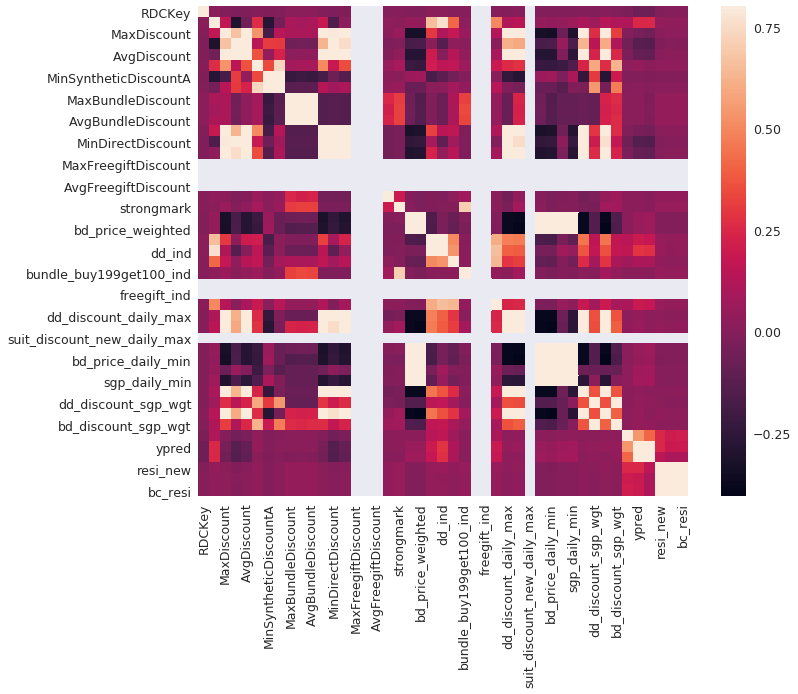

In [114]:
#correlation matrix
corrmat = new_raw_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [116]:
corrmat

,RDCKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,AvgBundleDiscount,MaxDirectDiscount,MinDirectDiscount,AvgDirectDiscount,MaxFreegiftDiscount,MinFreegiftDiscount,AvgFreegiftDiscount,numberproducts,strongmark,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,resi_new,log_resi,bc_resi
RDCKey,1.000000,0.013954,-0.003519,-0.013379,-0.009299,0.000083,-0.010381,-0.008279,0.012606,0.012214,0.012473,-0.006759,-0.014711,-0.011180,NaN,NaN,NaN,0.002540,0.002340,-0.006297,-0.007174,0.011373,0.010862,0.003676,0.002363,NaN,NaN,0.008194,-0.000564,0.002519,NaN,-0.006291,-0.007207,-0.005669,-0.008070,-0.000625,-0.006019,0.002443,-0.004388,-0.024693,-0.060837,-0.066055,-0.006942,0.005459,0.003574
PromotionCount,0.013954,1.000000,0.167996,-0.307173,-0.057628,0.268696,-0.276099,-0.045550,0.107890,0.089749,0.099621,0.186810,-0.156766,0.028839,NaN,NaN,NaN,0.032716,0.022443,0.046465,0.039556,0.657485,0.763014,0.416947,0.025633,NaN,NaN,0.501550,0.117580,0.150343,NaN,0.041394,0.033884,0.043968,0.069430,0.106028,0.072730,0.137862,0.121407,0.116588,0.250114,0.252140,0.042854,0.030101,0.032114
MaxDiscount,-0.003519,0.167996,1.000000,0.669953,0.910732,0.535716,-0.175360,0.142460,0.107922,0.106931,0.107907,0.951738,0.790926,0.903883,NaN,NaN,NaN,0.015037,0.056379,-0.324388,-0.332297,0.299079,0.114739,0.178947,0.057565,NaN,NaN,0.128480,0.838005,0.856974,NaN,-0.327105,-0.335075,-0.073822,-0.301641,0.837452,0.264848,0.855760,0.311460,-0.004748,-0.038514,-0.055621,0.019415,0.026497,0.025437
MinDiscount,-0.013379,-0.307173,0.669953,1.000000,0.904776,0.150480,0.307185,0.304216,-0.057152,-0.046766,-0.052368,0.627938,0.822225,0.757454,NaN,NaN,NaN,-0.017043,-0.005263,-0.172364,-0.167456,0.022901,-0.133638,0.033415,0.010849,NaN,NaN,0.013159,0.617876,0.589335,NaN,-0.171136,-0.166184,0.057172,-0.159539,0.628693,0.150099,0.598877,0.122600,-0.049880,-0.123069,-0.132740,-0.008733,0.002377,0.000668
AvgDiscount,-0.009299,-0.057628,0.910732,0.904776,1.000000,0.363037,0.039155,0.235545,0.027055,0.032116,0.029634,0.863134,0.889973,0.920169,NaN,NaN,NaN,-0.000753,0.029890,-0.281473,-0.283024,0.198809,0.008127,0.139172,0.041483,NaN,NaN,0.098239,0.816498,0.810501,NaN,-0.282124,-0.283653,-0.014311,-0.260696,0.823254,0.235311,0.816192,0.245549,-0.028584,-0.085865,-0.100550,0.006252,0.016296,0.014769
MaxSyntheticDiscountA,0.000083,0.268696,0.535716,0.150480,0.363037,1.000000,0.343669,0.735301,0.089143,0.092334,0.091062,0.505367,0.186435,0.350456,NaN,NaN,NaN,0.056554,0.094386,-0.217313,-0.228228,0.209034,0.159409,0.168119,0.065744,NaN,NaN,0.189333,0.258137,0.282259,NaN,-0.222169,-0.233092,-0.210803,-0.152607,0.239703,0.590886,0.264468,0.623201,0.028961,0.043263,0.024196,0.032447,0.031502,0.031701
MinSyntheticDiscountA,-0.010381,-0.276099,-0.175360,0.307185,0.039155,0.343669,1.000000,0.866973,-0.224892,-0.215118,-0.221529,-0.177460,-0.068804,-0.132705,NaN,NaN,NaN,0.015698,0.013088,0.060747,0.071714,-0.169061,-0.116137,-0.050592,0.000298,NaN,NaN,0.014229,-0.235290,-0.276124,NaN,0.060863,0.071838,-0.020286,0.107215,-0.239686,0.305527,-0.280909,0.198068,-0.006417,-0.008485,-0.012603,-0.002518,-0.003159,-0.003045
AvgSyntheticDiscountA,-0.008279,-0.045550,0.142460,0.304216,0.235545,0.735301,0.866973,1.000000,-0.124038,-0.115190,-0.120577,0.128135,0.071595,0.108086,NaN,NaN,NaN,0.040036,0.059030,-0.077801,-0.074824,0.013862,0.019080,0.086297,0.037656,NaN,NaN,0.139636,-0.012620,-0.033727,NaN,-0.079768,-0.076762,-0.126246,-0.008993,-0.022909,0.541802,-0.044064,0.474952,0.009649,0.014417,0.001870,0.013698,0.013300,0.013401
MaxBundleDiscount,0.012606,0.107890,0.107922

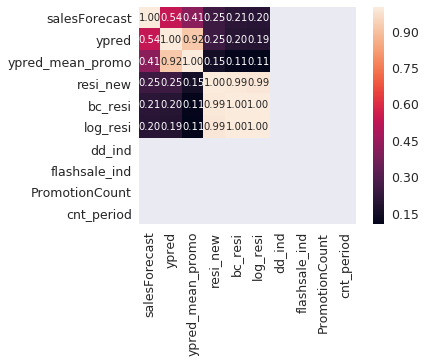

In [117]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'salesForecast')['salesForecast'].index
cm = np.corrcoef(raw_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

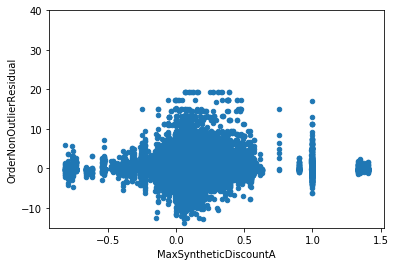

In [80]:
var = 'MaxSyntheticDiscountA'
data = pd.concat([raw_df['OrderNonOutlierResidual'], raw_df[var]], axis=1)
data.plot.scatter(x=var, y='OrderNonOutlierResidual', ylim=(-15,40));

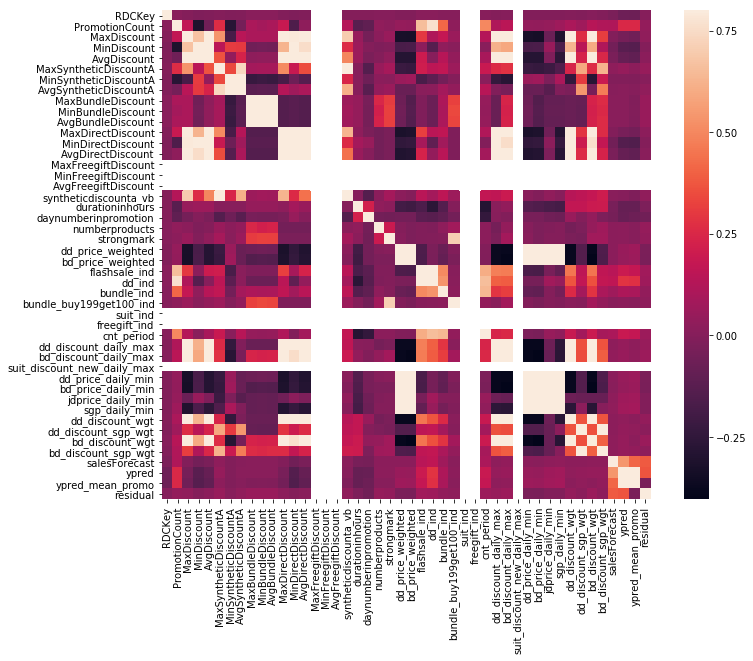

In [36]:
#correlation matrix
corrmat = raw_train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [35]:
corrmat

,RDCKey,PromotionCount,MaxDiscount,MinDiscount,AvgDiscount,MaxSyntheticDiscountA,MinSyntheticDiscountA,AvgSyntheticDiscountA,MaxBundleDiscount,MinBundleDiscount,...,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,salesForecast,ypred,ypred_mean_promo,residual
RDCKey,1.000000,0.013954,-0.003519,-0.013379,-0.009299,0.000083,-0.010381,-0.008279,0.012606,0.012214,...,-0.005669,-0.008070,-0.000625,-0.006019,0.002443,-0.004388,-0.024693,-0.060837,-0.066055,0.001535
PromotionCount,0.013954,1.000000,0.167996,-0.307173,-0.057628,0.268696,-0.276099,-0.045550,0.107890,0.089749,...,0.043968,0.069430,0.106028,0.072730,0.137862,0.121407,0.116588,0.250114,0.252140,0.040340
MaxDiscount,-0.003519,0.167996,1.000000,0.669953,0.910732,0.535716,-0.175360,0.142460,0.107922,0.106931,...,-0.073822,-0.301641,0.837452,0.264848,0.855760,0.311460,-0.004748,-0.038514,-0.055621,0.032755
MinDiscount,-0.013379,-0.307173,0.669953,1.000000,0.904776,0.150480,0.307185,0.304216,-0.057152,-0.046766,...,0.057172,-0.159539,0.628693,0.150099,0.598877,0.122600,-0.049880,-0.123069,-0.132740,0.000274
AvgDiscount,-0.009299,-0.057628,0.910732,0.904776,1.000000,0.363037,0.039155,0.235545,0.027055,0.032116,...,-0.014311,-0.260696,0.823254,0.235311,0.816192,0.245549,-0.028584,-0.085865,-0.100550,0.018608
MaxSyntheticDiscountA,0.000083,0.268696,0.535716,0.150480,0.363037,1.000000,0.343669,0.735301,0.089143,0.092334,...,-0.210803,-0.152607,0.239703,0.590886,0.264468,0.623201,0.028961,0.043263,0.024196,0.051739
MinSyntheticDiscountA,-0.010381,-0.276099,-0.175360,0.307185,0.039155,0.343669,1.000000,0.866973,-0.224892,-0.215118,...,-0.020286,0.107215,-0.239686,0.305527,-0.280909,0.198068,-0.006417,-0.008485,-0.012603,0.007991
AvgSyntheticDiscountA,-0.008279,-0.045550,0.142460,0.304216,0.235545,0.735301,0.866973,1.000000,-0.124038,-0.115190,...,-0.126246,-0.008993,-0.022909,0.541802,-0.044064,0.474952,0.009649,0.014417,0.001870,0.031538
MaxBundleDiscount,0.012606,0.107890,0.107922,-0.057152,0.027055,0.089143,-0.224892,-0.124038,1.000000,0.980367,...,-0.093070,-0.093089,-0.077597,-0.087944,0.232126,0.263406,0.012240,0.012587,-0.010032,0.054743
MinBundleDiscount,0.012214,0.089749,0.106931,-0.046766,0.032116,0.092334,-0.215118,-0.115190,0.980367,1.000000,...,-0.084681,-0.085498,-0.078654,-0.090543,0.225511,0.254219,0.013187,0.014178,-0.007959,0.053916
